In [190]:
!pip install mido
!pip install pygame
!pip install music21

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [191]:
import pandas as pd
import numpy as np
from mido import MidiFile
import pygame
import IPython
import matplotlib.pyplot as plt
import librosa.display
import keras.layers as L
import keras.models as M
import keras
from keras.layers import SimpleRNN,LSTM,GRU
from sklearn.model_selection import train_test_split
from IPython import *
from music21 import *
import os
import tensorflow as tf

In [192]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [193]:
data=pd.read_csv('../input/musicnet-dataset/musicnet_metadata.csv')

In [194]:
# Making live plots
# Importing the mid file first
mid=MidiFile('../input/musicnet-dataset/musicnet_midis/musicnet_midis/Beethoven/2313_qt15_1.mid',clip=True)
# Having a look at the tracks of the mid file
mid.tracks

[<midi track 'L.v.Beethoven 1mov - String Quartet No.15 in A minor Op.132\x00' 325 messages>,
 <midi track 'Violin1' 3277 messages>,
 <midi track 'Violin2' 2898 messages>,
 <midi track 'Viola' 2916 messages>,
 <midi track 'Cello' 2491 messages>,
 <midi track 'Violin1 Sub' 40 messages>]

In [195]:
# Having a look at the msges of the tracks let's have a look at the first one since it only have 325 messages
for i in mid.tracks[1] :
    print(i)

<meta message track_name name='Violin1' time=0>
control_change channel=0 control=0 value=0 time=0
program_change channel=0 program=40 time=0
control_change channel=0 control=7 value=100 time=0
control_change channel=0 control=10 value=20 time=0
control_change channel=0 control=91 value=127 time=0
<meta message key_signature key='Am' time=0>
control_change channel=0 control=11 value=127 time=0
note_on channel=0 note=69 velocity=1 time=0
note_off channel=0 note=69 velocity=100 time=188
control_change channel=0 control=11 value=90 time=2860
note_on channel=0 note=63 velocity=40 time=24
control_change channel=0 control=11 value=100 time=24
control_change channel=0 control=11 value=114 time=24
control_change channel=0 control=11 value=127 time=24
note_off channel=0 note=63 velocity=100 time=692
note_on channel=0 note=64 velocity=45 time=4
note_off channel=0 note=64 velocity=100 time=764
control_change channel=0 control=11 value=70 time=4
note_on channel=0 note=72 velocity=90 time=0
control_

In [196]:
# Well you can see clearly there are many meta messages here how will we solve that ??
# I got an idea let's get all the values with note on here 
note_on=[]
n=10
for m in range(n):
    mid=MidiFile('../input/musicnet-dataset/musicnet_midis/musicnet_midis/Beethoven/'+os.listdir('../input/musicnet-dataset/musicnet_midis/musicnet_midis/Beethoven')[m],clip=True)
    for j in range(len(mid.tracks)):
        for i in mid.tracks[j] :
            if str(type(i))!="<class 'mido.midifiles.meta.MetaMessage'>" :
                x=str(i).split(' ')
                if x[0]=='note_on':
                    note_on.append(int(x[2].split('=')[1]))

In [197]:
import time
from IPython.display import clear_output
def live_plot_make(x,range_=20,pause_time=0.01,skip_a_do=1):
    for i in range(0,len(x)-range_,skip_a_do):
        plt.figure(figsize=(18,8))
        x_plot=x[i:i+range_]
        y_plot=[i for i in range(range_)]
        fig=plt.plot(y_plot,x_plot,marker='D')
        plt.ylim([min(x),max(x)])
        time.sleep(pause_time)
        clear_output(wait=True)
        plt.show()


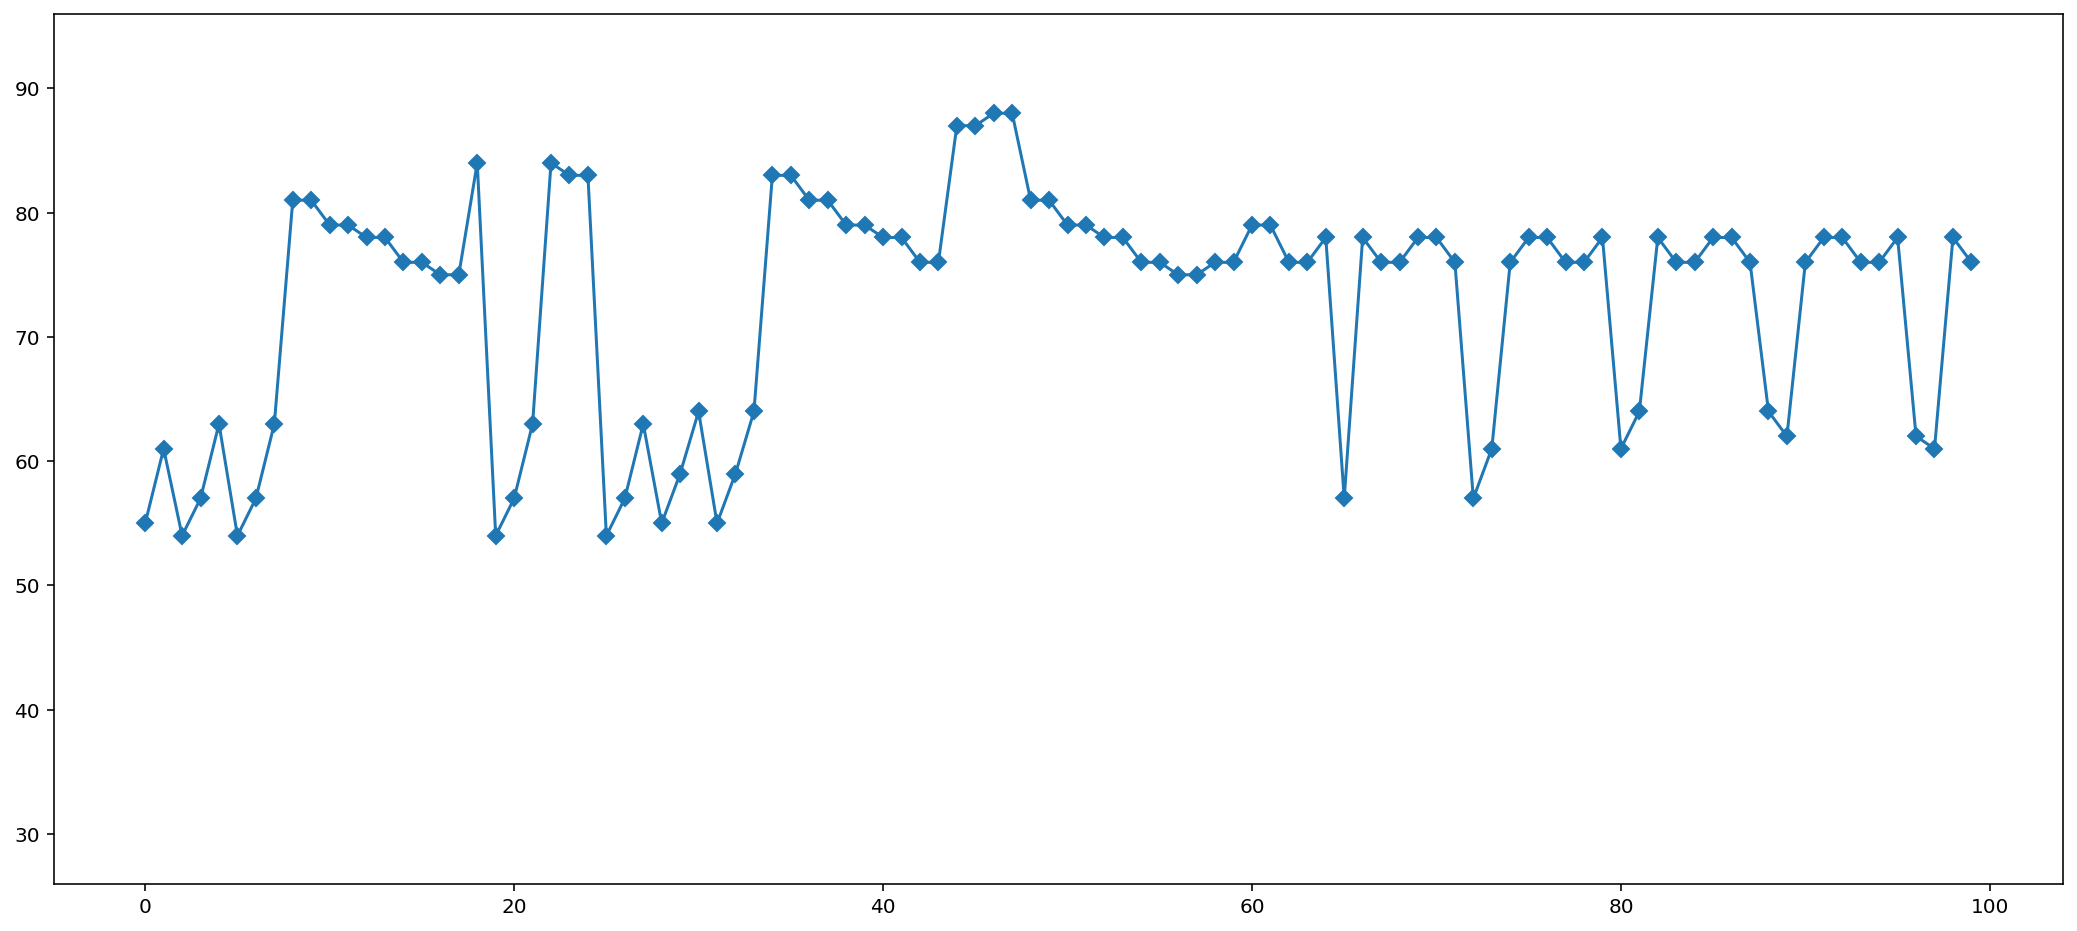

In [198]:
live_plot_make(note_on,range_=100,pause_time=0.02,skip_a_do=1000)

## Hehe something i created from scratch :) Hope you like this animated plot :)
## You might need to save this to gif if you wanna add it in markdown

# First Step Creating Data For Our Model

In [199]:
len(note_on)

45734

In [200]:
'''We are gonna take a frame of 10 notes at a time since we have 1437 notes takin 10 notes at a time will give us
        about 1427 training samples . Lets try :)'''
training_data=[]
labels=[]
for i in range(20,len(note_on)):
    training_data.append(note_on[i-20:i])
    labels.append(note_on[i])

In [201]:
print('Training data is :',training_data[0],' The label for it is :',labels[0])

Training data is : [82, 82, 80, 77, 74, 75, 70, 70, 68, 65, 62, 63, 55, 82, 82, 80, 77, 74, 75, 70]  The label for it is : 70


In [202]:
# How many different type of notes can we have in the labels column
different_labels=set(labels)
print('The different type of labels that we can have and might need to predict are : ',len(different_labels))

The different type of labels that we can have and might need to predict are :  71


In [203]:
# Function to build the model
def build_model():
    model=M.Sequential()
    model.add(LSTM(128,input_shape=(10,1)))
    model.add(L.Dense(1,'relu'))
    model.compile(loss='MSE',optimizer='adam')
    return model

In [204]:
def build_model_softmax():
    model=M.Sequential()
    model.add(LSTM(128,input_shape=(10,1),return_sequences=True))
    model.add(LSTM(128))
    model.add(L.Flatten())
    model.add(L.Dense(40,'relu'))
    model.add(L.Dense(40,'softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam')
    return model

In [205]:
def build_model_lstm2():
    model=M.Sequential()
    model.add(LSTM(200,input_shape=(10,1),unroll=True,return_sequences=True))
    model.add(L.Dropout(0.4))
    model.add(LSTM(100))
    model.add(L.Dense(100,'relu'))
    model.add(L.Dropout(0.2))
    model.add(L.Dense(1,'relu'))
    model.compile(loss='MSE',optimizer='adam')
    return model

In [206]:
def build_model_softmax():
    model=M.Sequential()
    model.add(LSTM(200,input_shape=(10,1),unroll=True,return_sequences=True))
    model.add(L.Dropout(0.4))
    model.add(LSTM(100))
    model.add(L.Dense(100,'relu'))
    model.add(L.Dropout(0.2))
    model.add(L.Dense(1,'relu'))
    model.compile(loss='MSE',optimizer='adam')
    return model

In [207]:
with strategy.scope():
    model=build_model_lstm2()

In [208]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=0)

In [209]:
training_data=np.array(training_data)
training_data=training_data.reshape((training_data.shape[0],training_data.shape[1],1))
labels=np.array(labels)

In [210]:
# Let's make training and validation data
X_train, X_test, y_train, y_test = train_test_split(training_data, labels, test_size=0.05, random_state=42)

In [211]:
X_train.shape

(43428, 20, 1)

In [212]:
model.fit(X_train,y_train,epochs=50,batch_size=32 * strategy.num_replicas_in_sync,
          validation_data=(X_test,y_test),callbacks=[early_stop])

Epoch 1/50
1358/1358 [==============================] - 15s 8ms/step - loss: 528.9352 - val_loss: 50.6245
Epoch 2/50
1358/1358 [==============================] - 11s 8ms/step - loss: 75.4273 - val_loss: 50.5790
Epoch 3/50
1358/1358 [==============================] - 11s 8ms/step - loss: 74.2711 - val_loss: 49.1242
Epoch 4/50
1358/1358 [==============================] - 11s 8ms/step - loss: 72.0229 - val_loss: 47.8132
Epoch 5/50
1358/1358 [==============================] - 11s 8ms/step - loss: 71.8618 - val_loss: 55.4967
Epoch 6/50
1358/1358 [==============================] - 11s 8ms/step - loss: 69.5144 - val_loss: 46.2938
Epoch 7/50
1358/1358 [==============================] - 11s 8ms/step - loss: 70.1243 - val_loss: 45.6188
Epoch 8/50
1358/1358 [==============================] - 11s 8ms/step - loss: 68.1099 - val_loss: 45.2612
Epoch 9/50
1358/1358 [==============================] - 11s 8ms/step - loss: 66.1413 - val_loss: 46.3812
Epoch 10/50
1358/1358 [==============================]

In [213]:
# Saving the model
model.save('Auto_Song_Maker.h5')

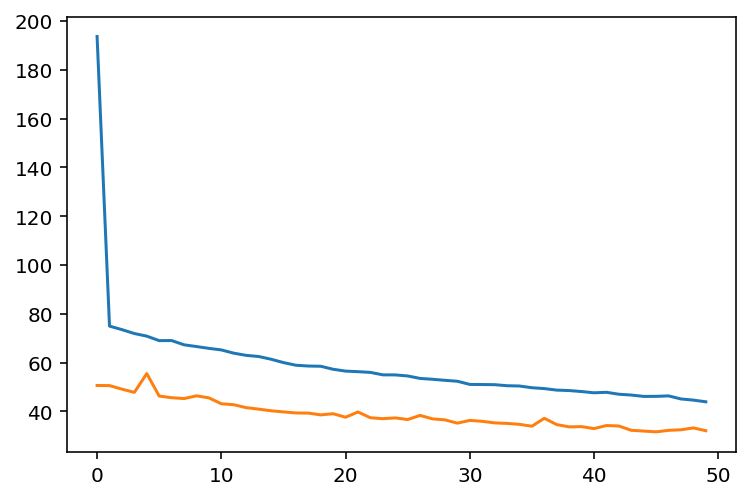

In [214]:
history=model.history.history
plt.plot([i for i in range(len(history['loss']))],history['loss'])
plt.plot([i for i in range(len(history['val_loss']))],history['val_loss'])

In [215]:
training_data[0].reshape(1,20,1)

array([[[82],
        [82],
        [80],
        [77],
        [74],
        [75],
        [70],
        [70],
        [68],
        [65],
        [62],
        [63],
        [55],
        [82],
        [82],
        [80],
        [77],
        [74],
        [75],
        [70]]])

In [216]:
model.predict(training_data[0].reshape(1,20,1))[0][0]

70.68298

In [217]:
###### Let's do some random predictions now
n=200
starter_notes=training_data[0]
x=training_data[0].reshape(1,20,1)
tune=list(training_data[0].reshape(-1,))
for i in range(n) :
    pred=int(model.predict(x)[0][0])
    if round(pred)==round(tune[-1]):
        p=np.random.choice(['a','b','c'])
        if p=='a':
            pred=65
        elif p=='b':
            pred=60
        else:
            pred=70
    tune.append(pred)
    x=tune[-10:]
    x=np.array(x)
    x=x.reshape(1,10,1)
    

In [218]:
tune=list(np.array(tune).astype('float32'))

# That was just one song :) Don't know how much chaos will occur after n songs :)

In [219]:
offset = 0
output_notes = []
# create note and chord objects based on the values generated by the model
for patterns in tune:
    pattern=str(patterns)
    # pattern is a chord
    if ('.' in pattern) or pattern.isdigit():
        notes_in_chord = pattern.split('.')
        notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            notes.append(new_note)
        new_chord = chord.Chord(notes)
        new_chord.offset = offset
        output_notes.append(new_chord)
    # pattern is a note
    else:
        new_note = note.Note(pattern)
        new_note.offset = offset
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)
    # increase offset each iteration so that notes do not stack
    offset += 0.5

In [220]:
output_notes

[<music21.chord.Chord B-5 C>,
 <music21.chord.Chord B-5 C>,
 <music21.chord.Chord G#5 C>,
 <music21.chord.Chord F5 C>,
 <music21.chord.Chord D5 C>,
 <music21.chord.Chord E-5 C>,
 <music21.chord.Chord B-4 C>,
 <music21.chord.Chord B-4 C>,
 <music21.chord.Chord G#4 C>,
 <music21.chord.Chord F4 C>,
 <music21.chord.Chord D4 C>,
 <music21.chord.Chord E-4 C>,
 <music21.chord.Chord G3 C>,
 <music21.chord.Chord B-5 C>,
 <music21.chord.Chord B-5 C>,
 <music21.chord.Chord G#5 C>,
 <music21.chord.Chord F5 C>,
 <music21.chord.Chord D5 C>,
 <music21.chord.Chord E-5 C>,
 <music21.chord.Chord B-4 C>,
 <music21.chord.Chord B-4 C>,
 <music21.chord.Chord C5 C>,
 <music21.chord.Chord B4 C>,
 <music21.chord.Chord B-4 C>,
 <music21.chord.Chord B4 C>,
 <music21.chord.Chord B-4 C>,
 <music21.chord.Chord B-4 C>,
 <music21.chord.Chord A4 C>,
 <music21.chord.Chord C4 C>,
 <music21.chord.Chord D4 C>,
 <music21.chord.Chord C#4 C>,
 <music21.chord.Chord C4 C>,
 <music21.chord.Chord B3 C>,
 <music21.chord.Chord B-4

In [221]:
midi_stream = stream.Stream(output_notes)


In [222]:
midi_stream.write('midi','test_output.mid')

'test_output.mid'